In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the CSV file into a DataFrame
df = pd.read_csv('../data/BTC-USD.csv')
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

print(df.head(3))

        Date          Open          High           Low         Close  \
0 2022-01-01  46311.746094  47827.312500  46288.484375  47686.812500   
1 2022-01-02  47680.925781  47881.406250  46856.937500  47345.218750   
2 2022-01-03  47343.542969  47510.726563  45835.964844  46458.117188   

      Adj Close       Volume  
0  47686.812500  24582667004  
1  47345.218750  27951569547  
2  46458.117188  33071628362  


# General Description of the data

In [9]:
print("the data has {} rows and {} columns".format(df.shape[0], df.shape[1]))

the data has 902 rows and 7 columns


In [10]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,902.000000,902.000000,902.000000,902.000000,902.000000,9.020000e+02
mean,34411.719876,35060.999792,33742.727624,34432.815075,34432.815075,2.562684e+10
std,14975.537897,15311.549158,14614.834202,15005.143731,15005.143731,1.322687e+10
min,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,5.331173e+09
25%,23030.899903,23415.710938,22666.192871,23031.511719,23031.511719,1.623811e+10
50%,29302.543946,29797.241211,28961.661133,29301.174805,29301.174805,2.389209e+10
75%,42246.697266,43049.487304,41541.421875,42249.030273,42249.030273,3.173584e+10
max,73079.375000,73750.070313,71334.093750,73083.500000,73083.500000,1.189925e+11


# Check for missing data

In [11]:
# missing data
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       902 non-null    datetime64[ns]
 1   Open       902 non-null    float64       
 2   High       902 non-null    float64       
 3   Low        902 non-null    float64       
 4   Close      902 non-null    float64       
 5   Adj Close  902 non-null    float64       
 6   Volume     902 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 49.5 KB
None


# Visualization

In [13]:
# Filter the data for the last 365 days
end_date = df['Date'].max()
start_date = end_date - timedelta(days=365)
df_last_365_days = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]


# Plot the volume of stocks daily for the last 365 days

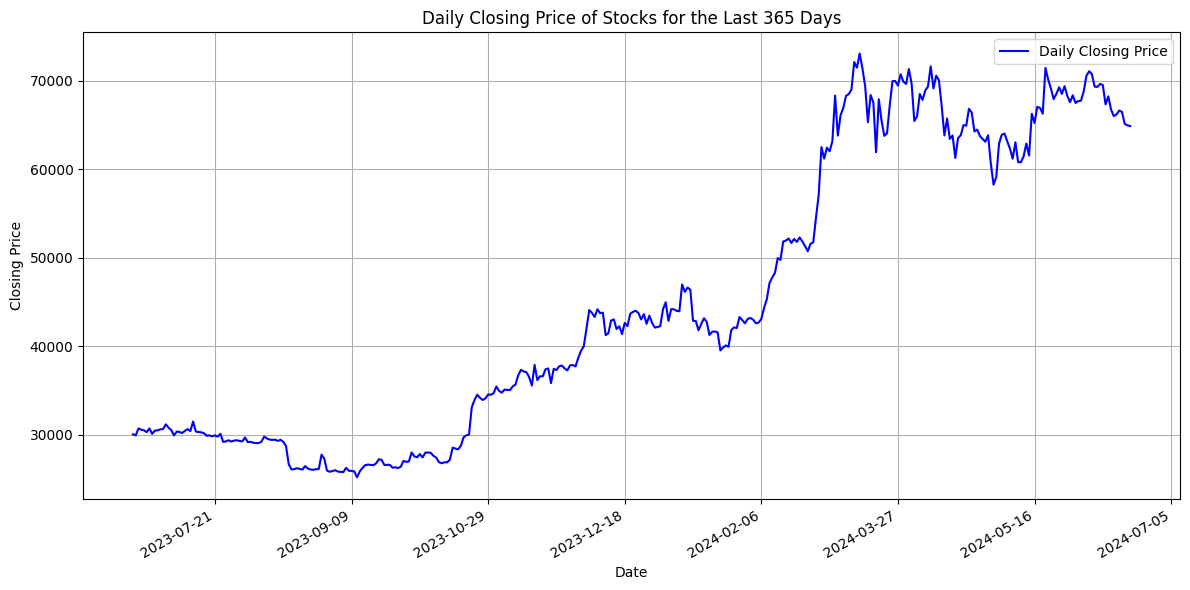

In [14]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(df_last_365_days['Date'], df_last_365_days['Close'], label='Daily Closing Price', color='blue')

# Set the locator to show dates at intervals of 50 days
locator = mdates.DayLocator(interval=50)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price of Stocks for the Last 365 Days')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Backtesting - Simple Moving Average (SMA)

In [35]:
# Calculate the 20-day Simple Moving Average (SMA)
df['SMA_20'] = df['Close'].rolling(window=12).mean()

## Moving Average Convergence Divergence (MACD)

In [36]:
# Calculate the MACD and Signal Line
df['EMA_12'] = df['Close'].ewm(span=6, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=12, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()


## SMA Trading Signal

In [37]:
# Create a trading signal based on SMA
df['SMA_Signal'] = 0
df.loc[df['Close'] > df['SMA_20'], 'SMA_Signal'] = 1
df.loc[df['Close'] < df['SMA_20'], 'SMA_Signal'] = -1

## Backtest the Strategy

## MACD Trading Signal

In [38]:
# Create a trading signal based on MACD
df['MACD_Signal'] = 0
df.loc[df['MACD'] > df['Signal_Line'], 'MACD_Signal'] = 1
df.loc[df['MACD'] < df['Signal_Line'], 'MACD_Signal'] = -1

# Backtest the Strategy

/tmp/ipykernel_6294/215571476.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'].iloc[i] = positions
/tmp/ipykernel_6294/215571476.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Portfolio_Value'].iloc[i] = capital + positions * df['Close'].iloc[i]


Final portfolio value: 146408.44


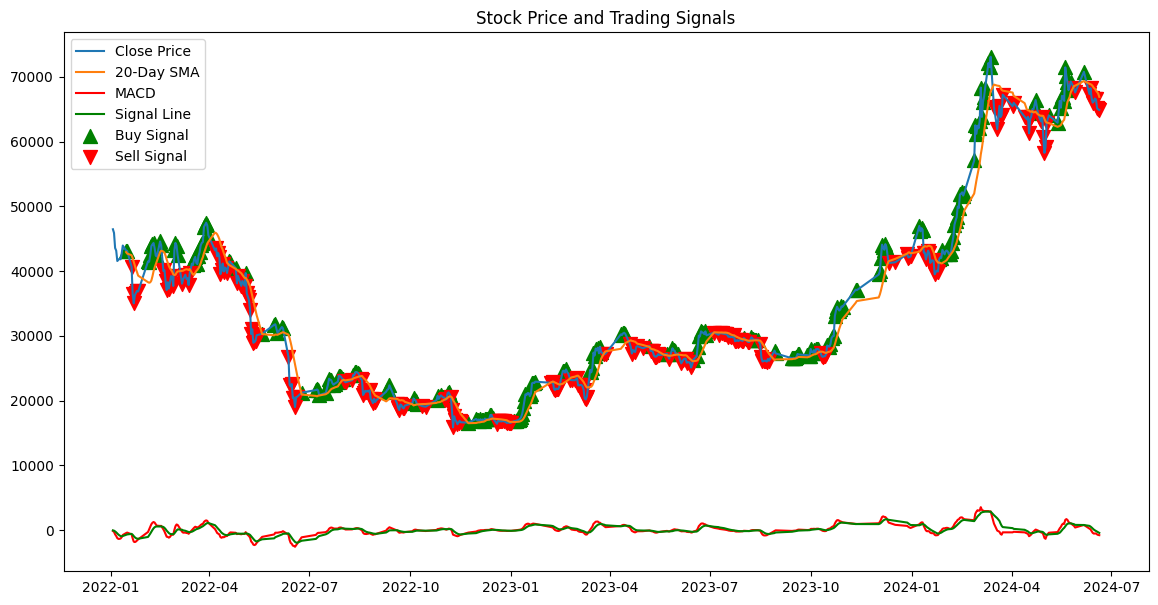

Final Return: 0.46
Number of Trades: 540
Winning Trades: 137
Losing Trades: 144
Max Drawdown: 0.44
Sharpe Ratio: 0.67


In [39]:
# Combine signals
df['Signal'] = df['SMA_Signal'] + df['MACD_Signal']

# Remove rows with zero signals
df = df[df['Signal'] != 0].copy()

# Remove rows with zero signals
df = df[df['Signal'] != 0]

# Backtest logic
initial_capital = 100000
capital = initial_capital
positions = 0
df['Position'] = 0
df['Portfolio_Value'] = 0.0

for i in range(len(df)):
    if df['Signal'].iloc[i] == 2 and positions == 0:  # Buy signal
        positions = capital / df['Close'].iloc[i]
        capital = 0
    elif df['Signal'].iloc[i] == -2 and positions > 0:  # Sell signal
        capital = positions * df['Close'].iloc[i]
        positions = 0
    df['Position'].iloc[i] = positions
    df['Portfolio_Value'].iloc[i] = capital + positions * df['Close'].iloc[i]

# Calculate the final portfolio value
final_portfolio_value = capital + positions * df['Close'].iloc[-1]
print(f'Final portfolio value: {final_portfolio_value:.2f}')

# Plotting the strategy
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['SMA_20'], label='20-Day SMA')
plt.plot(df['Date'], df['MACD'], label='MACD', color='r')
plt.plot(df['Date'], df['Signal_Line'], label='Signal Line', color='g')
plt.scatter(df['Date'][df['Signal'] == 2], df[df['Signal'] == 2]['Close'], marker='^', color='g', label='Buy Signal', s=100)
plt.scatter(df['Date'][df['Signal'] == -2], df[df['Signal'] == -2]['Close'], marker='v', color='r', label='Sell Signal', s=100)
plt.title('Stock Price and Trading Signals')
plt.legend()
plt.show()

# Calculate the daily returns
df['Daily_Return'] = df['Close'].pct_change()

# Calculate the strategy returns based on portfolio value changes
df['Strategy_Return'] = df['Portfolio_Value'].pct_change()

# Fill NaN values
df.fillna(0, inplace=True)

# Calculate the cumulative returns
df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod() - 1
df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return']).cumprod() - 1

# Calculate the final return
final_return = df['Cumulative_Strategy_Return'].iloc[-1]
print(f'Final Return: {final_return:.2f}')

# Calculate the number of trades
number_of_trades = df['Signal'].abs().sum() // 2
print(f'Number of Trades: {number_of_trades}')

# Calculate winning and losing trades
# Calculate the profits from each trade
df['Trade_Return'] = df['Strategy_Return'].where(df['Signal'] != 0)

# Separate winning and losing trades
winning_trades = df['Trade_Return'][df['Trade_Return'] > 0].count()
losing_trades = df['Trade_Return'][df['Trade_Return'] < 0].count()

print(f'Winning Trades: {winning_trades}')
print(f'Losing Trades: {losing_trades}')

# Calculate the running maximum of the cumulative return
df['Cumulative_Max'] = df['Cumulative_Strategy_Return'].cummax()

# Calculate the drawdown
df['Drawdown'] = df['Cumulative_Max'] - df['Cumulative_Strategy_Return']

# Calculate the maximum drawdown
max_drawdown = df['Drawdown'].max()
print(f'Max Drawdown: {max_drawdown:.2f}')

# Calculate the annualized return and standard deviation of returns
annual_return = df['Strategy_Return'].mean() * 252
annual_volatility = df['Strategy_Return'].std() * np.sqrt(252)

# Assume a risk-free rate (e.g., 0 for simplicity)
risk_free_rate = 0

# Calculate the Sharpe ratio
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# Important metrics from backtesting